# Prediction of child's IQ
Julia Krysiak, Sylwia Michalska

## Introduction
In this project we created two different models for predicting child's IQ based on the characteristics of the mother. Despite the controversy surrounding the measurement and significance of IQ, there are practical reasons why predicting IQ can still be useful.

### Controversy around IQ
IQ, or Intelligence Quotient, has long been a subject of debate. Critics argue that IQ tests are culturally biased, do not capture the full spectrum of human intelligence, and may not accurately reflect an individual's cognitive abilities or potential. Research has shown that factors such as socio-economic status, educational opportunities, and even test anxiety can significantly impact IQ scores, calling into question their reliability and validity as a measure of intelligence.

Furthermore, multiple studies suggest that intelligence is multifaceted and cannot be encapsulated by a single numerical score. Howard Gardner's theory of multiple intelligences, for instance, proposes that individuals possess a variety of distinct cognitive abilities, such as linguistic, logical-mathematical, spatial, and interpersonal intelligences, which are not adequately assessed by traditional IQ tests.

### Why prediction of IQ may be useful
While IQ is a controversial measure with significant limitations, its prediction can still offer practical benefits. IQ scores remain widely used in educational and psychological assessments for several practical reasons:
1. Educational Planning: IQ scores can help identify children who may need special educational support. Schools and educators can use this information to tailor educational strategies, design individualized education programs (IEPs), and allocate resources effectively.
2. Parental Guidance: Predicting a child's IQ based on socio-economic and parental factors can provide valuable insights for parents. Understanding how their actions and environment influence their child's cognitive development can help them make informed decisions about education, health, and enrichment activities.
3. Policy Making: Policy makers can use aggregated IQ data to inform decisions on early childhood education programs, social welfare initiatives, and resource allocation. For instance, identifying regions with lower average IQ scores may prompt interventions to improve educational and socio-economic conditions.
4. Research: IQ data, despite its limitations, provides a useful benchmark for psychological and educational research. It can help researchers study the impact of various factors on cognitive development and evaluate the effectiveness of interventions aimed at improving educational outcomes.

## Directed Acyclic Graph


<img title="Directed Acyclic Graph" src="images/children’s IQ.png">

## Data Source and Contents
We used `kidiq` dataset which is available in the [`statsmodels`](https://www.statsmodels.org/dev/datasets/index.html) datasets package. Data includes information on children's IQ scores and various socio-economic and parental factors. It contains following variables:

- **kid_score**: child's IQ score,
- **mom_hs**: indicator for whether the mother has a high school degree, which takes values from the set: {0,1},
- **mom_work**: value designed to capture and categorize the employment status of a mother during the early years of her child's life as follows:

    - 1 -> did not work in first three years of child's life,
    - 2 -> worked in 2nd or 3rd year of child's life,
    - 3 -> worked part-time in first year of child's life,
    - 4 -> worked full-time in first year of child's life.

- **mom_age**: mother's age.



## Data preprocessing


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import arviz as az
from cmdstanpy import CmdStanModel

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Firstly, we have displayed the data to see the structure and samples of data records:

In [4]:
df = pd.read_csv("data/kidiq.csv", sep=";")
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


Next, we have checked if there are any null values in our dataset:

In [8]:
df.isnull().sum()

kid_score    0
mom_hs       0
mom_iq       0
mom_work     0
mom_age      0
dtype: int64

We also have used the `describe` function to check the statistics regards the dataframe and provide more details about the each column of data:

In [10]:
df.describe()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
count,99.000000,99.000000,99.000000,99.000000,99.000000
mean,91.363636,0.818182,103.149581,2.838384,23.383838
std,17.374303,0.387657,15.415122,1.201250,2.686729
min,42.000000,0.000000,76.575647,1.000000,17.000000
25%,79.500000,1.000000,90.772626,2.000000,21.500000
50%,95.000000,1.000000,100.534072,3.000000,24.000000
75%,103.500000,1.000000,113.411657,4.000000,25.000000
max,130.000000,1.000000,138.893106,4.000000,29.000000


Finally, we have analysed the correlation between the data. This step involves calculating the correlation coefficients between different variables in the dataset to understand the relationships between them. What we found is that there is moderate positive $kid.score$ ~
` $mom.iq$ and $kid.score$ ~ $mom.hs$ correlation. This indicates that those could be good predictiors for our models. The variables dependencies were presented using the corallation matrix visualized with a heatmap.

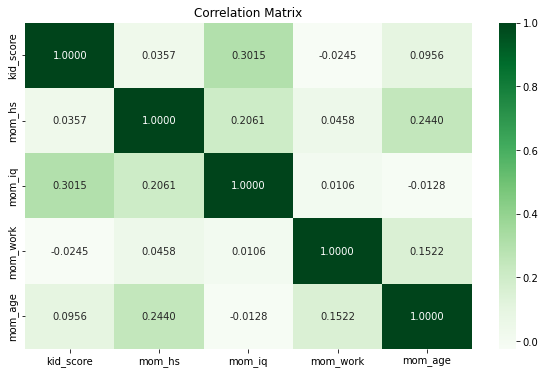

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True,cmap='Greens', fmt=".4f")
plt.title('Correlation Matrix')
plt.show()

### Plotting data

To see the dependencies between the variables which we chose to further consideration as the parameters in our models, we have created the following plots to show:

- dependency beetwen the child and mom IQ score:

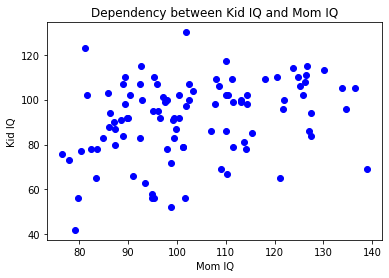

In [20]:
plt.scatter(df.mom_iq.values, df.kid_score.values, color='blue')
plt.title("Dependency between Kid IQ and Mom IQ")
plt.xlabel("Mom IQ")
plt.ylabel("Kid IQ")
plt.show()

- dependency beetwen the child IQ score and mom hs indicator:

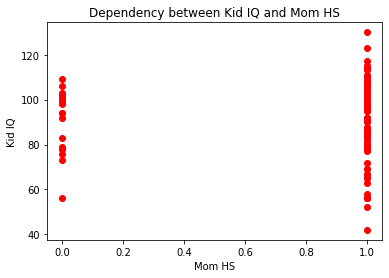

In [26]:
plt.scatter(df.mom_hs.values, df.kid_score.values, color='red')
plt.title("Dependency between Kid IQ and Mom HS")
plt.xlabel("Mom HS")
plt.ylabel("Kid IQ")
plt.show()

The purpose of the visualization of the variables:  `kid_score` , `mom_iq`, and `mom_hs` using the histograms was to show the distribution of that data for a better understanding of the respective characteristics and dependencies and also to check the potential outliers:

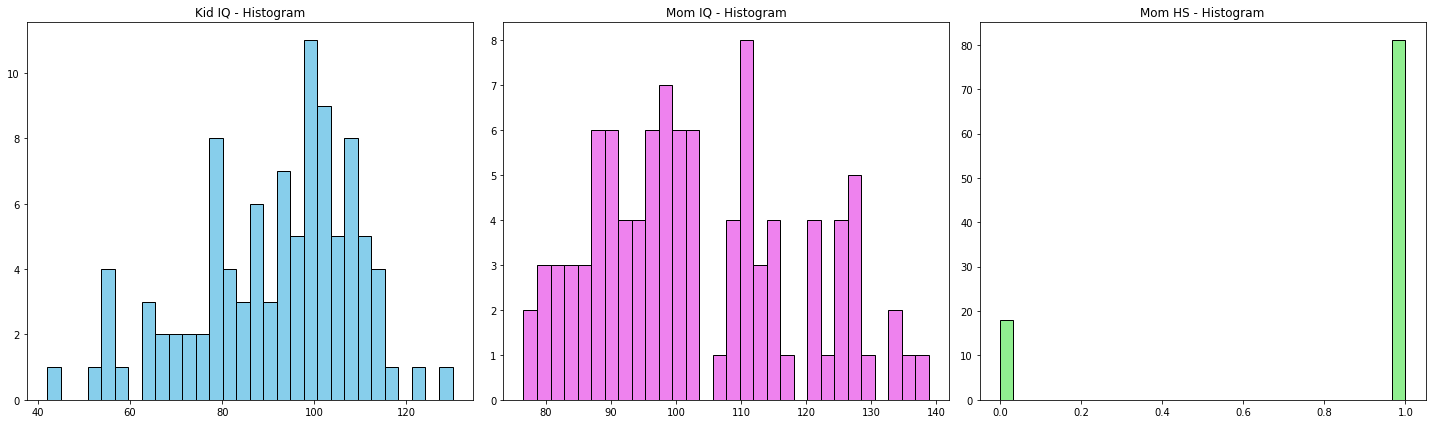

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Kid IQ - Histogram')

axs[1].hist(df.mom_iq.values, bins=30, color='violet', edgecolor='black')
axs[1].set_title('Mom IQ - Histogram')

axs[2].hist(df.mom_hs.values, bins=30, color='lightgreen', edgecolor='black')
axs[2].set_title('Mom HS - Histogram')

plt.tight_layout()
plt.show()

# First model
Our first model is a simple linear regression model designed to predict a child's IQ score based on the mother's IQ score. This foundational model allows us to investigate the relationship between these two variables and serves as a starting point for more complex analyses. It can be described as:
$$kid.score_i \sim N(\mu_i, \sigma)$$
$$\mu_i = \beta_0 + \beta_1mom.iq_i$$


## Priors
In selecting priors for our Bayesian model, we considered both the characteristics of the given data and the distributions recommended by Mark Lai in his book "Course Handouts for Bayesian Data Analysis Class" (2019). Below, we briefly describe each parameter and its corresponding prior distribution:
1. $\beta_0$ - regression intercept: this is the expected IQ score of a child when the mother's IQ score is zero; chosen prior distribution:
$$\beta_0 \sim N(90, 15)$$
2. $\beta_1$ - slope: indicates the expected change in a child's IQ score for each one-point increase in the mother's IQ score, this parameter captures the strength and direction of the relationship between maternal and child IQ; chosen prior distribution:
$$\beta_1 \sim N(0, 1)$$
3. $\sigma$ - error standard deviation: represents the variability of child IQ scores among those with the same maternal IQ score, it accounts for the unobserved factors affecting child IQ and is assumed to be constant across different levels of maternal IQ; chosen prior distribution (recommended in Gelman, Andrew. 2006. “Prior distributions for variance parameters in hierarchical models (Comment on Article by Browne and Draper).” Bayesian Analysis 1 (3): 515–34):
$$\sigma \sim t^+(4, 0, 1)$$






### STAN

```stan
data {
  int<lower=0> N;               
  array[N] real mom_iq;        
}

generated quantities {
  real beta0 = normal_rng(90, 15);   
  real beta1 = normal_rng(0, 1);     
  real sigma = student_t_rng(4, 0, 1);

  array[N] real kid_score; 
  for (i in 1:N) {
    kid_score[i] = normal_rng(beta0 + beta1*mom_iq[i], sigma);  
  }
}

```

### Simulating data
Centering mother's IQ scores by subtracting the mean ensures that the intercept $\beta_0$ accurately reflects the expected child's IQ score when the mother's IQ is average. Subsequently, we created a simulated dataset that closely mimics the range and distribution of the actual data. The decision to simulate the data comes from the necessity to validate its functionality and to gain insights into its behavior under controlled conditions.

In [5]:
mean_mom_iq = df.mom_iq.mean()
df['c_mom_iq'] = df.mom_iq - mean_mom_iq
data_sim={'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(), num=df.shape[0])}

In [6]:
model_1=CmdStanModel(stan_file='stan_models/prior1.stan')

model_1_samp = model_1.sample(data = data_sim, chains=4, seed=2904)

INFO:cmdstanpy:compiling stan file /home/DA/project/kidiq/stan_models/prior1.stan to exe file /home/DA/project/kidiq/stan_models/prior1
INFO:cmdstanpy:compiled model executable: /home/DA/project/kidiq/stan_models/prior1
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [7]:
kid_pred_prior = model_1_samp.stan_variable("kid_score")

In [8]:
print(model_1_samp.summary())

                Mean   MCSE  StdDev   5%  50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                        
lp__            0.00    NaN    0.00  0.0  0.0    0.0     NaN      NaN    NaN
beta0          45.00  0.780   47.00  0.0  0.0  110.0  3500.0   8300.0    1.0
beta1           0.02  0.011    0.71 -1.2  0.0    1.3  4000.0   9400.0    1.0
sigma           0.49  0.013    0.80  0.0  0.0    2.1  3900.0   9200.0    1.0
kid_score[1]   44.00  0.830   50.00  0.0  0.0  128.0  3623.0   8504.0    1.0
...              ...    ...     ...  ...  ...    ...     ...      ...    ...
kid_score[95]  46.00  0.870   53.00  0.0  0.0  140.0  3646.0   8560.0    1.0
kid_score[96]  46.00  0.880   53.00  0.0  0.0  141.0  3645.0   8557.0    1.0
kid_score[97]  46.00  0.880   53.00  0.0  0.0  142.0  3628.0   8516.0    1.0
kid_score[98]  46.00  0.880   53.00  0.0  0.0  142.0  3644.0   8553.0    1.0
kid_score[99]  46.00  0.890   54.00  0.0  0.0  142.0  3644.0   8553.0    1.0

### Sampled slopes
For each sampled slope beta and intercept alpha lines has been plotted. Slopes are more or less between minimum and maximum possible IQs which would imply that the chosen priors are satisfactory.

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


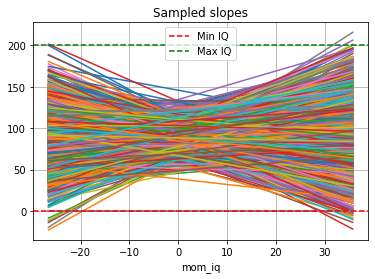

In [9]:
betas0 = model_1_samp.stan_variable('beta0')
betas1 = model_1_samp.stan_variable('beta1')

mom_iq = data_sim['mom_iq']

for beta0, beta1 in zip(betas0, betas1):
    plt.plot(mom_iq, mom_iq * beta1 + beta0)
    plt.xlabel('mom_iq')

min_iq = 0 
max_iq = 200 

plt.axhline(y=min_iq, color='red', linestyle='--', label='Min IQ')
plt.axhline(y=max_iq, color='green', linestyle='--', label='Max IQ')

plt.grid(True)
plt.legend()
plt.title("Sampled slopes")
plt.show()

### Comparison of measurements

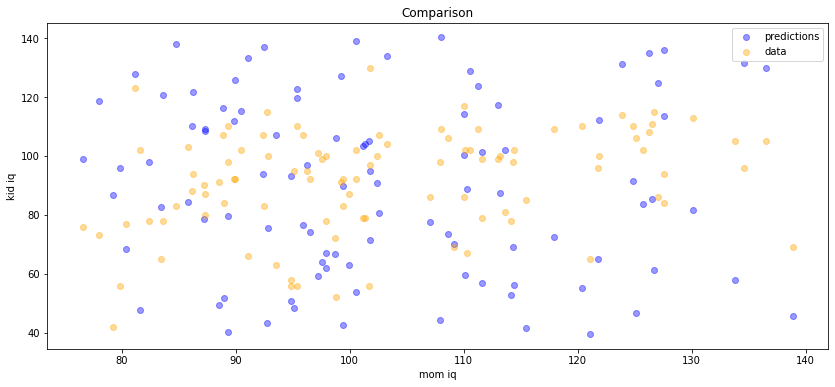

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,kid_pred_prior[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

## Posterior

### STAN
```stan
data {
  int<lower=0> N;               
  array[N] real mom_iq;  
  array[N] real kid_score;      
}

parameters {
  real beta0;
  real beta1;
  real sigma;

}

model {
  beta0 ~ normal(90, 15);   
  beta1 ~ normal(0, 1); 
  sigma ~ student_t(4,0,1);
  for (i in 1:N) {
    kid_score[i] ~ normal(beta0 + beta1 * mom_iq[i], sigma);  
  }
}
generated quantities {

    array[N] real<lower=0> kid_score_pred; 
    array[N] real log_lik;

    for (i in 1:N) {
        log_lik[i] = normal_lpdf(kid_score[i] | beta0 + beta1 * mom_iq[i], sigma);
        kid_score_pred[i] = normal_rng(beta0 + beta1 * mom_iq[i], sigma);  
    }
}

```

In [37]:
model=CmdStanModel(stan_file='stan_models/model1_b.stan')

model_1_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df.mom_iq.values, 'kid_score': df.kid_score.values},
                     chains=4)

INFO:cmdstanpy:compiling stan file /home/kidiq/stan_models/model1_b.stan to exe file /home/kidiq/stan_models/model1_b
INFO:cmdstanpy:compiled model executable: /home/kidiq/stan_models/model1_b
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


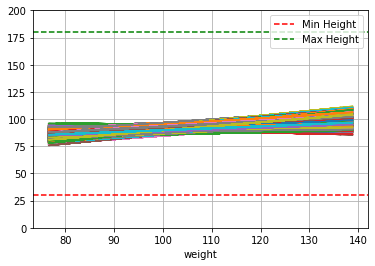

In [1815]:
alphas = model_1_fit.stan_variable('beta0')
betas = model_1_fit.stan_variable('beta1')
weight = df['mom_iq']
for alpha, beta in zip(alphas, betas):
    plt.plot(weight, weight * beta + alpha)
    plt.xlabel('weight')
# Check consistency with minimum and maximum heights observed in nature
min_height_observed = 30 # minimum observed height
max_height_observed = 180 # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height')
plt.ylim([0, 200])
plt.grid(True)
plt.legend()

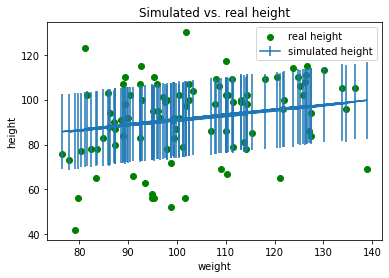

In [1816]:
heights = model_1_fit.stan_variable('kid_score_pred')
mean_heights = np.mean(heights,axis=0,)
std_heights = np.std(heights,axis=0)
real_heights = np.array(df['kid_score'])
plt.errorbar(weight, mean_heights, yerr=std_heights, label='simulated height')
plt.scatter(weight, real_heights,label='real height', color ='green')
plt.xlabel('weight')
plt.ylabel('height')
plt.title('Simulated vs. real height')
plt.legend()
plt.show()

In [1817]:
yields_pred = model_1_fit.stan_variable("kid_score_pred")
yields_pred_means = yields_pred
print(yields_pred_means[1])

[ 97.9861  79.8191  93.0862  95.421   97.9329 123.464  103.339  106.4
 100.506  108.239   91.602  108.953   69.0644  89.9186  90.6573 108.008
 113.423   86.1007  76.5996  94.7827 102.58    89.8167  99.3719  94.4803
 100.868   93.0454 105.932   88.072   78.4698  77.5462  99.5306 102.286
  82.5581 104.955   93.4641  79.847   97.4388  98.0413  69.5883  51.4677
  62.3912  81.0192  85.4356  73.3249  76.9668  88.9331  83.1209  79.4969
  92.0684  75.4588  69.0226 106.723  100.95   105.377   77.0814  99.6966
  89.8537 105.45    60.0832  79.5212  92.8344  73.8241 100.215   83.3091
  89.3239  86.5877  82.2775  71.3313  59.9599  86.9884  99.3771 103.014
  64.0223  99.5124  73.7312  74.5879  94.6501 102.987   67.0202  99.3682
  55.4428  76.0016 107.434  112.982  133.299   75.5409  96.1364  87.586
 116.203  106.666   87.9976 111.305   94.1778  75.4631  70.7419 104.908
  82.0278  90.8875  74.7302]


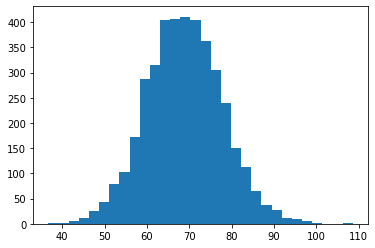

In [1818]:
beta0 = model_1_fit.stan_variable("beta0")
plt.hist(beta0, bins=30)
plt.show()

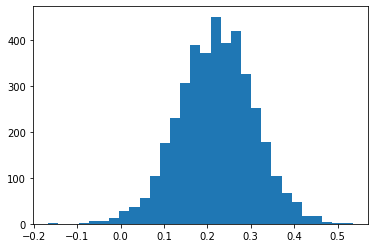

In [1819]:
beta1 = model_1_fit.stan_variable("beta1")
plt.hist(beta1, bins=30)
plt.show()

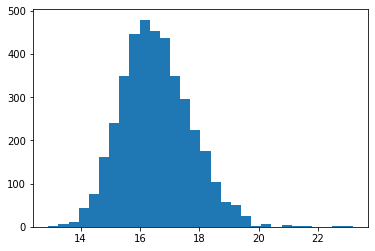

In [1820]:
sigma = model_1_fit.stan_variable("sigma")
plt.hist(sigma, bins=30)
plt.show()

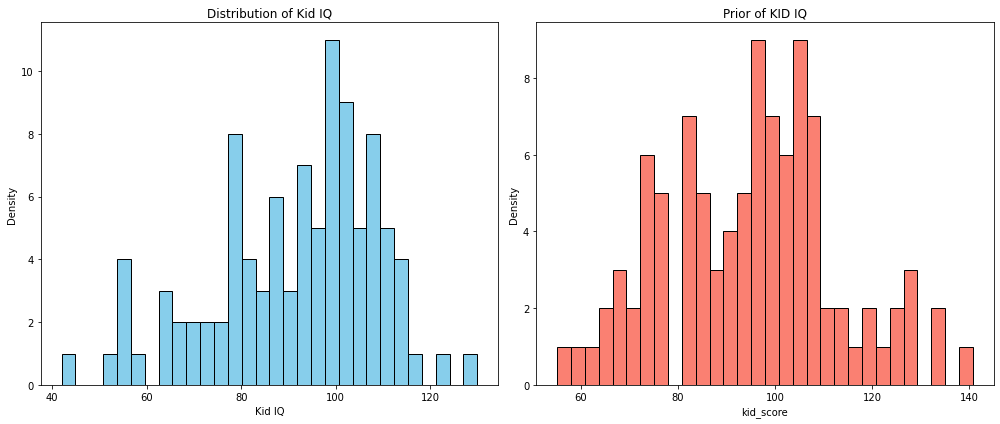

In [1821]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_means[0], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

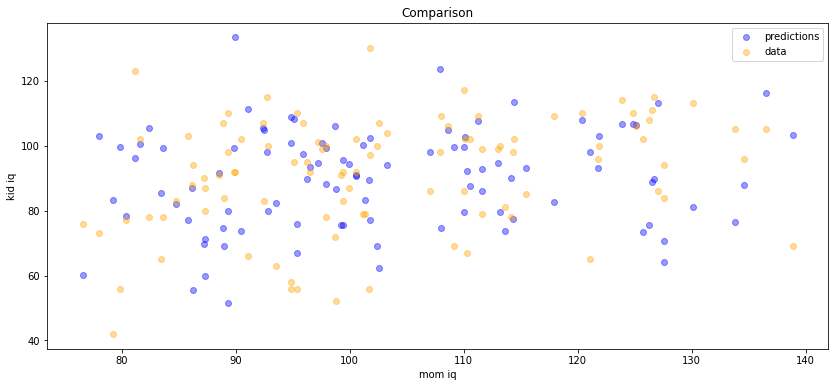

In [1822]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,yields_pred_means[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [1823]:
sum([(x - y)**2 for x,y in zip(yields_pred_means[0],df.kid_score)])

52537.79267377

# Second model

In [39]:
mean_weight = df['mom_iq'].mean()
df['c_mom_iq'] = df['mom_iq'] - mean_weight
data_sim2 = {'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(), num=df.shape[0]), 'mom_hs': np.random.choice([0, 1], size=df.shape[0], p=[0.2, 0.8])}
# data_sim2 = {'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(), num=df.shape[0]), 'mom_hs': df.mom_hs}

In [40]:
model_2=CmdStanModel(stan_file='stan_models/prior2.stan')

model_2_samp = model_2.sample(data = data_sim2,
                     chains=4,
                     seed=1204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [1826]:
yields_pred_prior = model_2_samp.stan_variable("kid_score")
# yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)
yields_pred_prior_means = yields_pred_prior

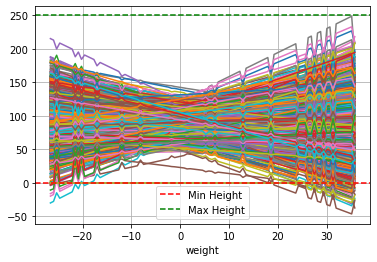

In [1827]:
betas0 = model_2_samp.stan_variable('beta0')
betas1 = model_2_samp.stan_variable('beta1')
betas2 = model_2_samp.stan_variable('beta2')
betas3 = model_2_samp.stan_variable('beta3')



weight = data_sim2['mom_iq']
hs = data_sim2['mom_hs']

for beta0, beta1, beta2, beta3 in zip(betas0, betas1, betas2, betas3):
    plt.plot(weight, beta0 + beta1*weight + beta2*hs + beta3*hs*weight)
    plt.xlabel('weight')
# Check consistency with minimum and maximum heights observed in nature
min_height_observed = 0 # minimum observed height
max_height_observed = 250 # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height')
# plt.ylim([-10, 270])
plt.grid(True)
plt.legend()

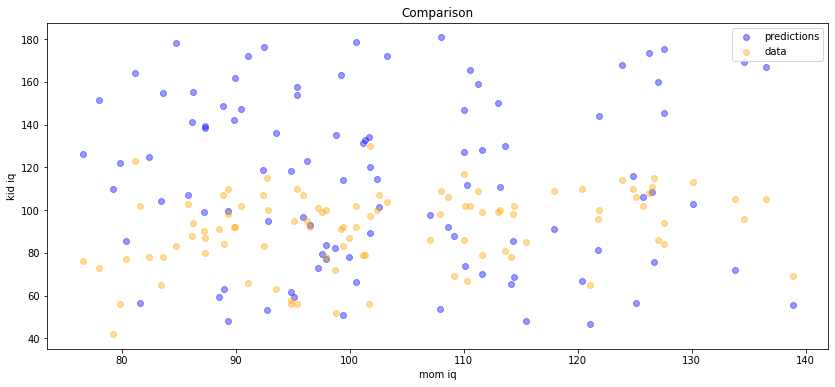

In [1828]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,yields_pred_prior_means[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [41]:
model=CmdStanModel(stan_file='stan_models/model2.stan')

model_2_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df.mom_iq, 'kid_score': df.kid_score, 'mom_hs': df["mom_hs"].values},
                     chains=4)

INFO:cmdstanpy:compiling stan file /home/kidiq/stan_models/model2.stan to exe file /home/kidiq/stan_models/model2
INFO:cmdstanpy:compiled model executable: /home/kidiq/stan_models/model2
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status









chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampl


INFO:cmdstanpy:CmdStan done processing.


In [1831]:
yields_pred = model_2_fit.stan_variable("kid_score_pred")
yields_pred_means = yields_pred

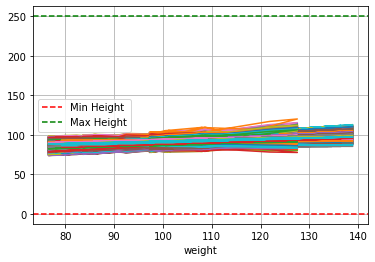

In [1832]:
betas0 = model_2_fit.stan_variable('beta0')
betas1 = model_2_fit.stan_variable('beta1')
betas2 = model_2_fit.stan_variable('beta2')
betas3 = model_2_fit.stan_variable('beta3')



weight = df['mom_iq']
hs = df['mom_hs']

for beta0, beta1, beta2, beta3 in zip(betas0, betas1, betas2, betas3):
    plt.plot(weight, beta0 + beta1*weight + beta2*hs + beta3*hs*weight)
    plt.xlabel('weight')
# Check consistency with minimum and maximum heights observed in nature
min_height_observed = 0 # minimum observed height
max_height_observed = 250 # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height')
# plt.ylim([-10, 270])
plt.grid(True)
plt.legend()

In [1833]:
yields_pred_means

array([[108.208 ,  94.1332,  80.1257, ...,  70.8087,  92.2889, 125.366 ],
       [115.099 ,  91.4255,  78.7592, ...,  65.0429,  61.0822,  97.3078],
       [ 93.4335,  97.8512,  52.4413, ..., 115.815 ,  86.3611, 112.985 ],
       ...,
       [ 80.6258,  60.3563,  96.536 , ...,  73.4675,  79.7335,  99.4437],
       [ 80.7604, 114.044 , 104.263 , ...,  85.9848, 102.956 ,  81.432 ],
       [ 67.689 ,  86.8743,  91.6635, ..., 120.342 ,  75.4534,  89.2879]])

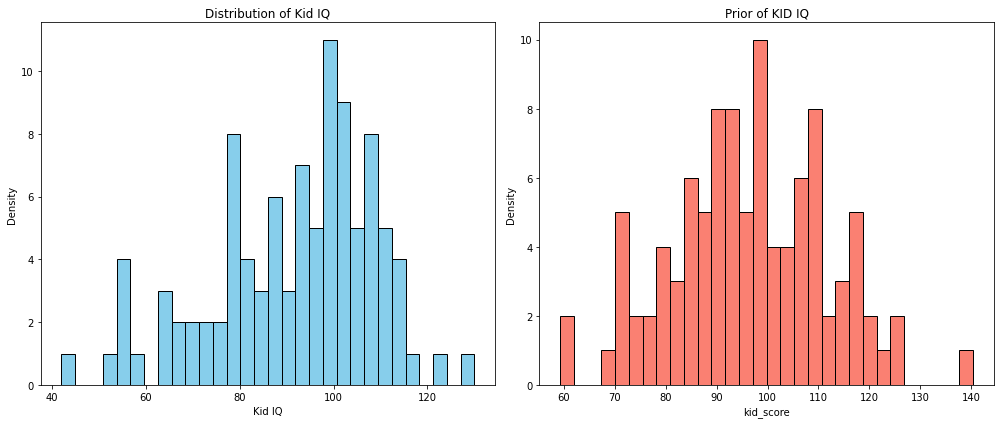

In [1834]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_means[0], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [1835]:
sum([(x - y)**2 for x,y in zip(yields_pred_means[0],df.kid_score)])

51362.43480015998

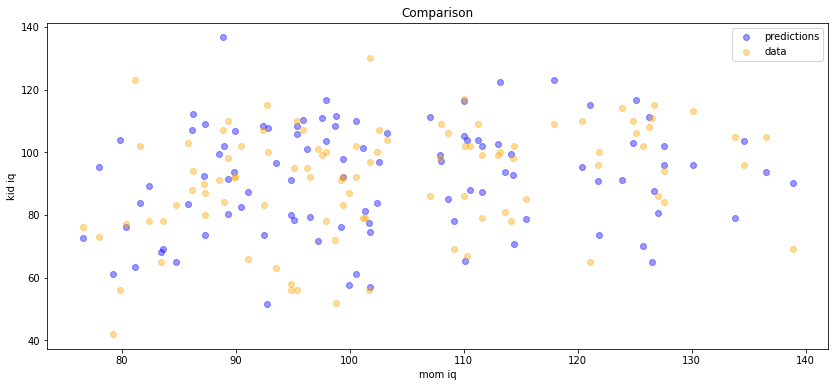

In [1836]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,yields_pred_means[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [1837]:
sigmas = model_2_fit.stan_variable('sigma')

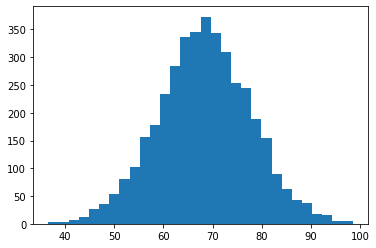

In [1838]:
plt.hist(betas0, bins=30)
plt.show()

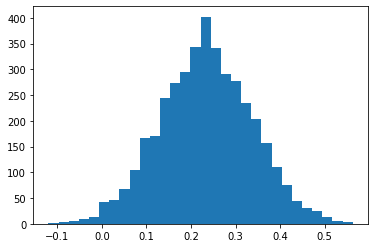

In [1839]:
plt.hist(betas1, bins=30)
plt.show()

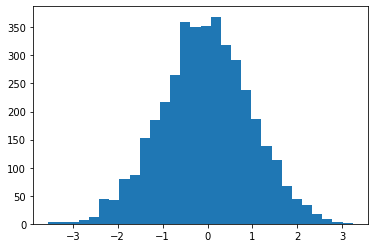

In [1840]:
plt.hist(betas2, bins=30)
plt.show()

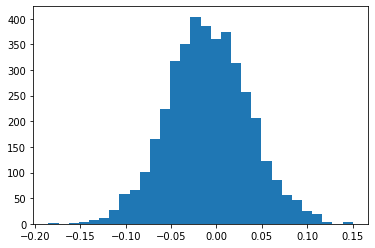

In [1841]:
plt.hist(betas3, bins=30)
plt.show()

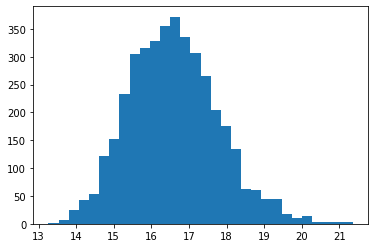

In [1842]:
plt.hist(sigmas, bins=30)
plt.show()

### Model comparison


- Leave-one-out Cross Validation

<AxesSubplot:xlabel='Deviance'>

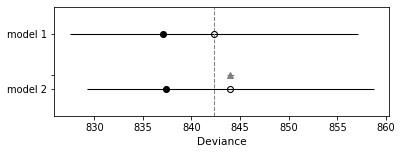

In [45]:
comparison_dict = {"model 1":model_1_fit, "model 2": model_2_fit}
comparison_loo = az.compare(comparison_dict, ic="loo",scale="deviance")
az.plot_compare(comparison_loo)

In [46]:
comparison_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model 1,0,842.288828,2.631999,0.000000,1.0,14.836843,0.000000,False,deviance
model 2,1,844.000626,3.297565,1.711798,0.0,14.769113,0.393881,False,deviance


- Widely Applicable Information Criterion

<AxesSubplot:xlabel='Deviance'>

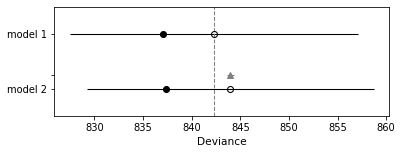

In [47]:
comparison_waic = az.compare(comparison_dict, ic="waic",scale="deviance")
az.plot_compare(comparison_waic)

In [48]:
comparison_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model 1,0,842.275395,2.625282,0.000000,1.0,14.833828,0.000000,False,deviance
model 2,1,843.974910,3.284706,1.699515,0.0,14.762370,0.392358,False,deviance
